In [1]:
%config IPCompleter.greedy=True

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string 
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS 
from html.parser import HTMLParser
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob, Word
import re

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif

from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [4]:
df_train = pd.read_csv('Dataset/train.csv')

In [5]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
df_train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

# Data Visualization

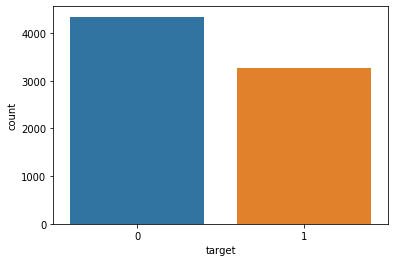

In [7]:
sns.countplot(x='target',data=df_train)

In [8]:
target1=len(df_train.loc[df_train.target==1])
target0=len(df_train.loc[df_train.target==0])

print('Target 0 as a percentage : {}'.format((target0)*100/(target1+target0)))
print('Target 1 as a percentage : {}'.format((target1)*100/(target1+target0)))

Target 0 as a percentage : 57.034020753973465
Target 1 as a percentage : 42.965979246026535


In [9]:
def getCombinedtext(df,text_column,target_column,target_value):
    """Generate a text combining the provided tweets """
    return " ".join(text for text in df.loc[df[target_column]==target_value][text_column].values)

In [10]:
def plotWordCloud(Text):
    """A form of visualizing the word frequency in a given text"""
    wordcloud = WordCloud(max_font_size=60,max_words=100,background_color='white').generate(Text)
    plt.imshow(wordcloud)

In [11]:
Text_Target0=getCombinedtext(df_train,'text','target',0)

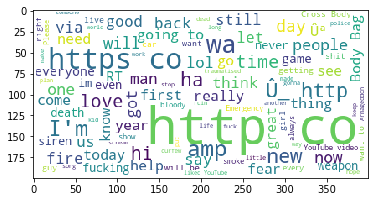

In [12]:
plotWordCloud(Text_Target0)

In [13]:
Text_Target1=getCombinedtext(df_train,'text','target',1)

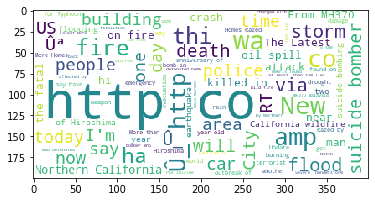

In [14]:
plotWordCloud(Text_Target1)

# Data Cleaning 

In [15]:
def remove_URL(text):
    """Removing URL"""
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_html(text):
    """Escaping HTML Characters"""
    html_parser = HTMLParser()
    return html_parser.unescape(text)

def convert_to_lower(text):
    """Convert the overall text into lowercase"""
    return text.lower()

def remove_stopwords(text):
    """Removing stopwords"""
    stopWords = set(stopwords.words('english'))
    return ' '.join([word for word in text.split() if word not in stopWords ])

def lemmatize_with_postag(text):
    """Lemmatize each word with its post tag"""
    sent = TextBlob(text)
    tag_dict = {"J": 'a', 
                "N": 'n', 
                "V": 'v', 
                "R": 'r'}
    words_and_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags] 
    lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]
    return " ".join(lemmatized_list)

def remove_punct(text):
    """Remove punctuations"""
    updated_text = ' '.join(TextBlob(text).words)
    table=str.maketrans('','',string.punctuation)
    return ' '.join([w.translate(table) for w in updated_text.split()])

def remove_numeric(text):
    """Filter the alphabetic words"""
    return ' '.join([word for word in text.split() if word.isalpha()])


In [17]:
def text_preprocessing (text):
    
    html_removed_text=remove_html(text)
    
    URL_removed_text = remove_URL(html_removed_text)
    
    lowercase_text = convert_to_lower(URL_removed_text)
    
    punct_removed_text = remove_punct(lowercase_text)
    
    numeric_removed_text = remove_numeric(punct_removed_text)
    
    stopwords_removed_text = remove_stopwords(numeric_removed_text)
    
    lemmatized_text = lemmatize_with_postag(stopwords_removed_text)
    
    return lemmatized_text
    

In [18]:
df_train['text']=df_train['text'].apply(text_preprocessing)

C:\Users\Acer\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:9: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  if __name__ == '__main__':


# Data Visualization - Cleaned Data

In [19]:
Updated_Text_Target0=getCombinedtext(df_train,'text','target',0)
Updated_Text_Target1=getCombinedtext(df_train,'text','target',1)

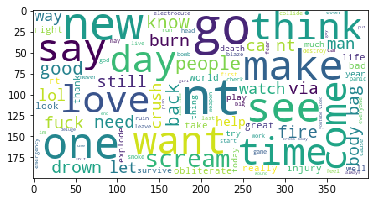

In [20]:
plotWordCloud(Updated_Text_Target0)

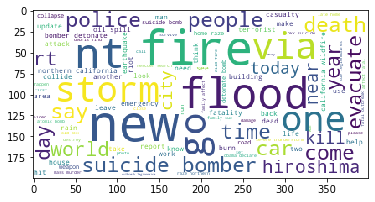

In [21]:
plotWordCloud(Updated_Text_Target1)

# Train Test Data Split

In [22]:
x_train,x_test,y_train,y_test=train_test_split(df_train['text'],df_train['target'],test_size=0.2,random_state=6)

In [23]:
x_train=pd.DataFrame(data=x_train,columns=['text'])
x_test=pd.DataFrame(data=x_test,columns=['text'])

# Model Selection

#Using Naive Bayes

In [226]:
pipeline = Pipeline([
    ('bow',CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors with Naive Bayes classifier
])

In [227]:

pipeline.fit(x_train['text'].values,y_train)
predictions = pipeline.predict(x_test['text'].values)
print(classification_report(predictions,y_test))
print(confusion_matrix(predictions,y_test))
print(accuracy_score(predictions,y_test))

              precision    recall  f1-score   support

           0       0.91      0.78      0.84      1011
           1       0.66      0.85      0.75       512

    accuracy                           0.80      1523
   macro avg       0.79      0.82      0.79      1523
weighted avg       0.83      0.80      0.81      1523

[[789 222]
 [ 75 437]]
0.8049901510177282


#Using Support Vector Machine 

In [24]:
pipeline = Pipeline([
    ('bow',CountVectorizer()),  
    ('tfidf', TfidfTransformer()), 
    ('selector',SelectPercentile(f_classif,percentile =80 )),
    ('classifier', SVC(kernel="rbf" , gamma=1)),  
])

In [25]:

pipeline.fit(x_train['text'].values,y_train)
predictions = pipeline.predict(x_test['text'].values)
print(classification_report(predictions,y_test))
print(confusion_matrix(predictions,y_test))
print(accuracy_score(predictions,y_test))

              precision    recall  f1-score   support

           0       0.90      0.78      0.84       994
           1       0.68      0.84      0.75       529

    accuracy                           0.80      1523
   macro avg       0.79      0.81      0.79      1523
weighted avg       0.82      0.80      0.81      1523

[[780 214]
 [ 84 445]]
0.804333552199606
